In [1]:
import numpy as np
import pandas as pd
from cmdstanpy import cmdstan_path, CmdStanModel
import matplotlib.pyplot as plt
import arviz as az
from model_testing import create_lags
import diagnostics

from datamodel import SPX, StockData

plt.rcParams["figure.figsize"] = (15,10)

In [2]:
spx = SPX()
vix_data = StockData(["^VIX"])

In [7]:
spx_wk_prices = spx.prices.resample("W-FRI").last()
spx_wk_returns = (np.log(spx_wk_prices) - np.log(spx_wk_prices.shift(1))).dropna()
vix_wk_prices = vix_data.prices.VIX["close"].resample("W-FRI").last()
spx_wk_vol = spx.vol.resample("W-FRI").sum()

wk_vix_lags = create_lags(vix_wk_prices, 4, "wk_vix")
wk_vol_lags = create_lags(spx_wk_vol, 4, "wk_vol")

x = pd.concat([np.log(np.square(wk_vix_lags / (100 * np.sqrt(52)))), np.log(wk_vol_lags)], axis=1).dropna()

common_index = x.index.intersection(spx_wk_returns.index)
x = x.loc[common_index]
y = spx_wk_returns.loc[common_index]

# Model 1

In [4]:
model_spec = """
    data {
        int N;                              // Length of data
        int M;                              // Exogenous regressors dimensions
        vector[N] r;                        // SPX returns
        matrix[N, M] x;                     // Exogenous regressors data
    }
    parameters {
        real mu_h;                          // Volatility mean term
        real mu_r;                          // Returns mean term
        vector[M] beta;                     // Exogenous regressors coefficients
        real<lower=0> sigma;                // Volatility noise
        vector[N] h_std;                    // Log volatility
    }
    transformed parameters {
        vector[N] h = h_std * sigma;        // h ~ normal(0, sigma);
        for (t in 1:N) {
            h[t] += mu_h + x[t] * beta;     // h ~ normal(mu_h + x * beta, sigma)
        }
    }
    model {
        beta ~ normal(0, 10);
        sigma ~ normal(0, 10);
        mu_h ~ normal(0, 10);
        mu_r ~ normal(0, 10);
        
        h_std ~ std_normal();
        r ~ normal(mu_r, exp(h / 2));
    }
    generated quantities {
        real r_tilde[N];
        real log_prob[N];
        r_tilde = normal_rng(mu_r, exp(h / 2));
        for (t in 1:N) {
            log_prob[t] = normal_lpdf(r[t] | mu_r, exp(h[t] / 2));  // Need log probabilities later on
        }
    }
"""
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model


In [8]:
data = {"N": len(y),
        "M": len(x.columns),
        "r": y.values,
        "x": x.values}
sample = model.sample(data=data,
                      chains=4,
                      parallel_chains=4,
                      output_dir="./stan_model",
                      iter_warmup=1000,
                      iter_sampling=2500,
                      show_progress=True)

Chain 1 - warmup:   0%|                                                                                                                                      | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|                                                                                                                                   | 0/3500 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                      | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                   | 0/3500 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                                                                                      | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                      

Chain 2 - sample:  31%|█████████████████████████████████████▋                                                                                  | 1100/3500 [01:04<02:11, 18.18it/s]


Chain 1 - sample:  34%|█████████████████████████████████████████▏                                                                              | 1200/3500 [01:08<01:42, 22.51it/s]

Chain 1 - sample:  37%|████████████████████████████████████████████▌                                                                           | 1300/3500 [01:12<01:35, 22.98it/s]


Chain 1 - sample:  40%|████████████████████████████████████████████████                                                                        | 1400/3500 [01:16<01:27, 24.11it/s]

Chain 1 - sample:  43%|███████████████████████████████████████████████████▍                                                                    | 1500/3500 [01:19<01:19, 25.10it/s]


Chain 4 - sample:  37%|████████████████████████████████████████████▌                        

Chain 2 - sample:  77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2700/3500 [02:44<00:47, 16.96it/s]


Chain 4 - sample:  71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 2500/3500 [02:46<01:06, 14.97it/s]

Chain 1 -   done: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [02:49<00:00, 27.17it/s]


Chain 4 - sample:  74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2600/3500 [02:53<01:00, 14.94it/s]

Chain 2 - sample:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2900/3500 [02:56<00:35, 16.76it/s]


Chain 4 - sample:  77%|█████████████████████████████████████████████████████████████████████

In [9]:
model1_data = az.from_cmdstanpy(posterior=sample,
                                posterior_predictive="r_tilde",
                                observed_data={"r": y.values},
                                log_likelihood="log_prob")

In [16]:
r_tilde = diagnostics.get_post_pred(model1_data)

array([[<AxesSubplot:title={'center':'mu_h'}>,
        <AxesSubplot:title={'center':'mu_h'}>],
       [<AxesSubplot:title={'center':'mu_r'}>,
        <AxesSubplot:title={'center':'mu_r'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

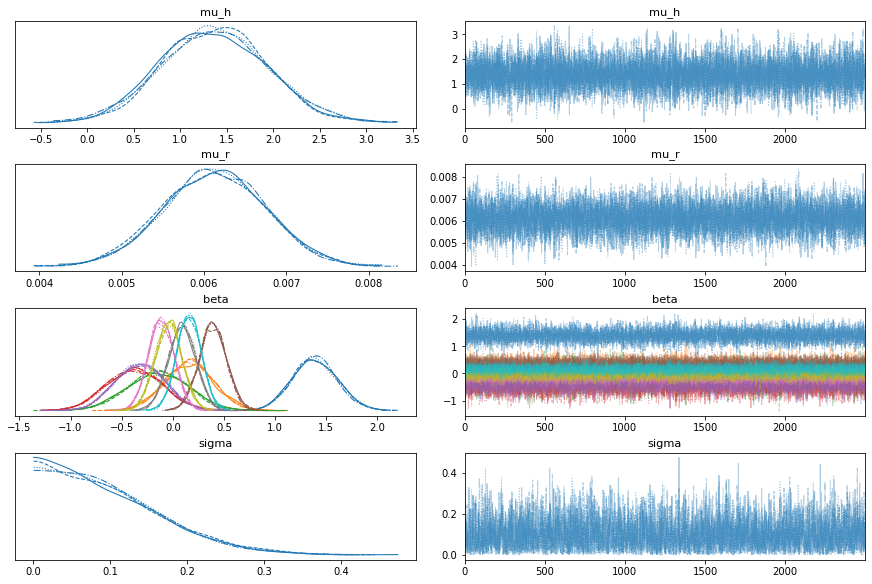

In [10]:
az.plot_trace(model1_data, compact=True, var_names=["mu_h", "mu_r", "beta", "sigma"])

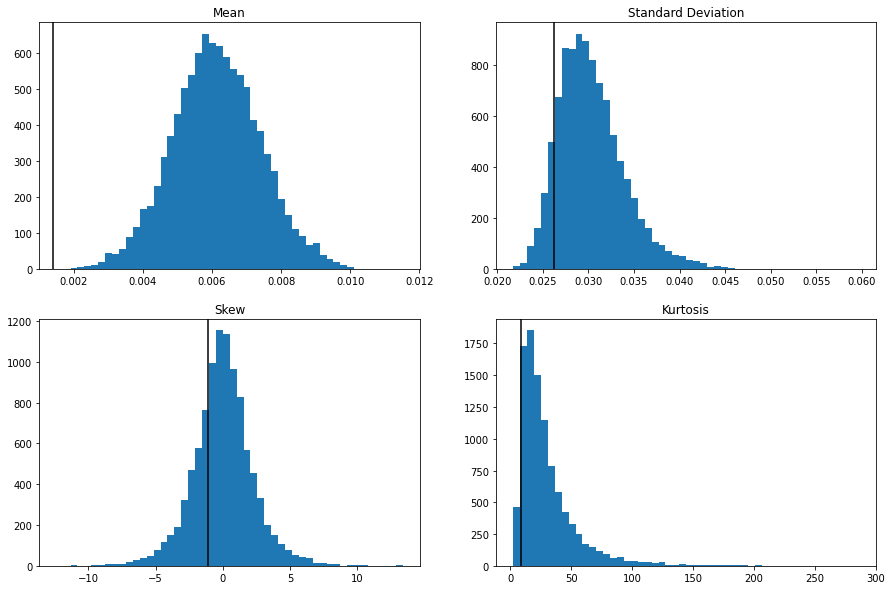

In [12]:
fig = diagnostics.plot_moment_checks(model1_data)

<AxesSubplot:xlabel='r / r_tilde'>

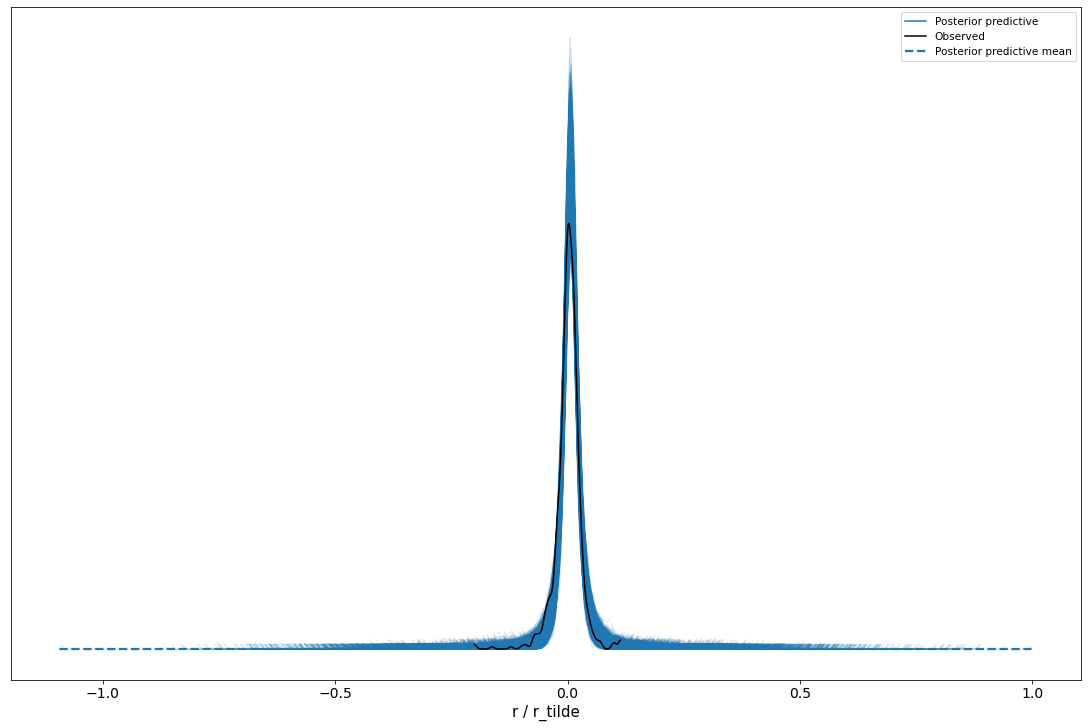

In [13]:
az.plot_ppc(model1_data, data_pairs={"r": "r_tilde"})

In [14]:
diagnostics.exceedances(model1_data)

{1: 0.13999999999999999,
 5: 2.98,
 10: 10.549999999999999,
 25: 31.39,
 50: 57.24,
 75: 77.66999999999999,
 90: 90.25999999999999,
 95: 95.26,
 99: 98.92}

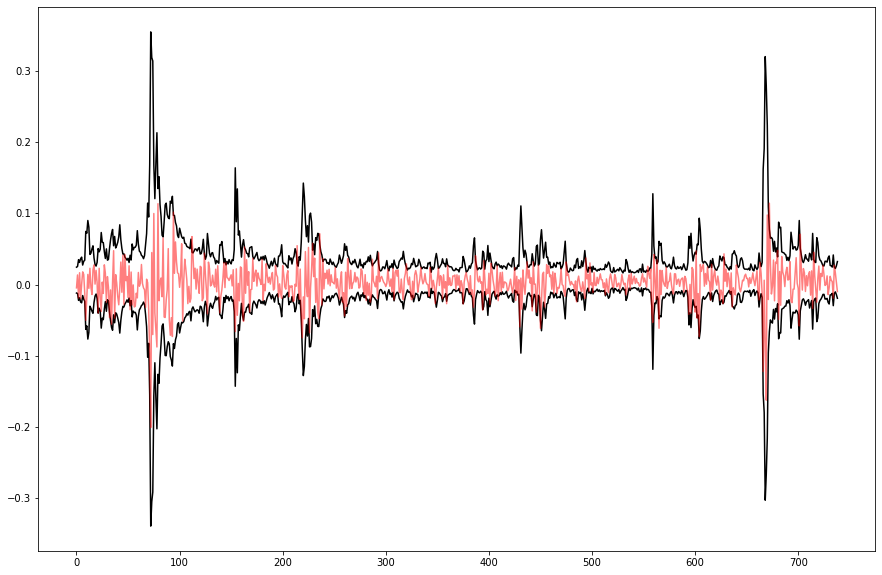

In [18]:
plt.plot(np.percentile(r_tilde, 95, axis=1), color="black")
plt.plot(np.percentile(r_tilde, 5, axis=1), color="black")
plt.plot(y.values, color="red", alpha=0.5)

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


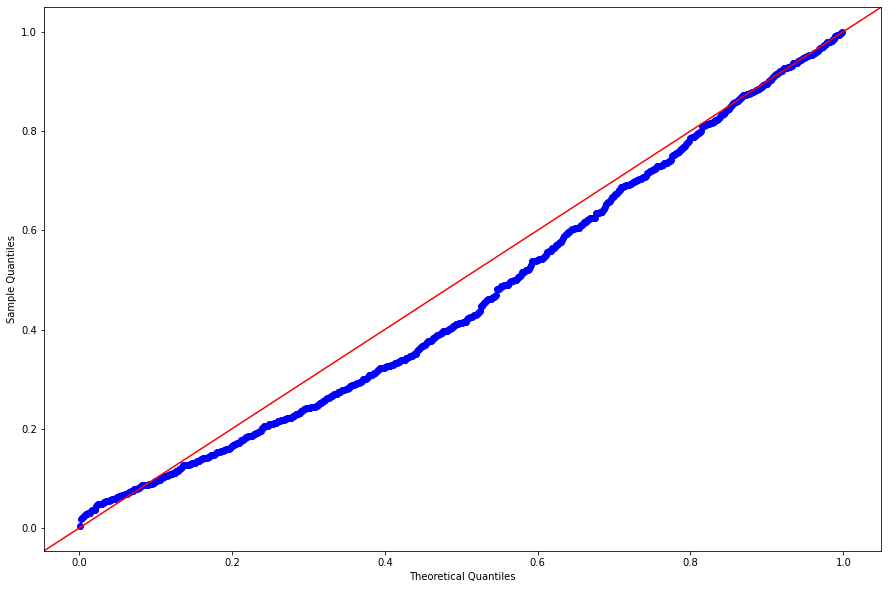

In [20]:
fig = diagnostics.plot_qq(model1_data)

In [21]:
model_vol = pd.Series(np.mean(model1_data.posterior.h.values.reshape(10000, -1), axis=0), index=y.index)
model_vol = np.sqrt(np.exp(model_vol))

<AxesSubplot:>

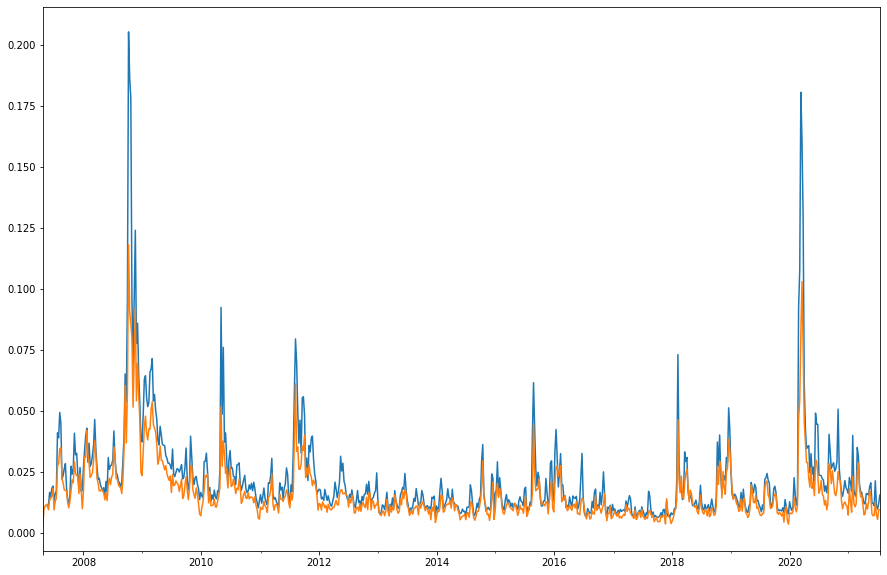

In [22]:
model_vol.plot()
np.sqrt(spx_wk_vol).plot()

# Model 2

In [33]:
model_spec = """
    data {
        int N;                              // Length of data
        int M;                              // Exogenous regressors dimensions
        vector[N] r;                        // SPX returns
        matrix[N, M] x;                     // Exogenous regressors data
    }
    parameters {
        real mu_h;                          // Volatility mean term
        real mu_r;                          // Returns mean term
        vector[M] beta;                     // Exogenous regressors coefficients
        real<lower=0> sigma;                // Volatility noise
        vector[N] h_std;                    // Log volatility
        real alpha;                         // Shape parameter
    }
    transformed parameters {
        vector[N] h = h_std * sigma;        // h ~ normal(0, sigma);
        for (t in 1:N) {
            h[t] += mu_h + x[t] * beta;     // h ~ normal(mu_h + x * beta, sigma)
        }
    }
    model {
        beta ~ normal(0, 10);
        sigma ~ normal(0, 10);
        mu_h ~ normal(0, 10);
        mu_r ~ normal(0, 10);
        alpha ~ normal(0, 10);
        
        h_std ~ std_normal();
        r ~ skew_normal(mu_r, exp(h / 2), alpha);
    }
    generated quantities {
        real r_tilde[N];
        real log_prob[N];
        r_tilde = skew_normal_rng(mu_r, exp(h / 2), alpha);
        for (t in 1:N) {
            log_prob[t] = skew_normal_lpdf(r[t] | mu_r, exp(h[t] / 2), alpha);  // Need log probabilities later on
        }
    }
"""
with open("./stan_model/model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/model.stan")

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/model


In [34]:
data = {"N": len(y),
        "M": len(x.columns),
        "r": y.values,
        "x": x.values}
sample = model.sample(data=data,
                      chains=4,
                      parallel_chains=4,
                      output_dir="./stan_model",
                      iter_warmup=1000,
                      iter_sampling=2500,
                      show_progress=True)

Chain 1 - warmup:   0%|                                                                                                                                      | 0/1 [00:00<?, ?it/s]

Chain 1 - warmup:   0%|                                                                                                                                   | 0/3500 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|                                                                                                                                   | 0/3500 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                                                                                      | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                                                                                   | 0/3500 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                      

Chain 4 - sample:  31%|█████████████████████████████████████▋                                                                                  | 1100/3500 [01:09<02:29, 16.01it/s]

Chain 1 - sample:  31%|█████████████████████████████████████▋                                                                                  | 1100/3500 [01:16<02:39, 15.06it/s]


Chain 4 - sample:  34%|█████████████████████████████████████████▏                                                                              | 1200/3500 [01:18<02:43, 14.05it/s]

Chain 1 - sample:  34%|█████████████████████████████████████████▏                                                                              | 1200/3500 [01:24<02:47, 13.74it/s]


Chain 4 - sample:  37%|████████████████████████████████████████████▌                                                                           | 1300/3500 [01:26<02:46, 13.19it/s]

Chain 1 - sample:  37%|████████████████████████████████████████████▌                         

Chain 1 - sample:  71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 2500/3500 [03:11<01:19, 12.60it/s]


Chain 4 - sample:  74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2600/3500 [03:14<01:12, 12.43it/s]

Chain 1 - sample:  74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2600/3500 [03:19<01:11, 12.58it/s]


Chain 4 - sample:  77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2700/3500 [03:22<01:04, 12.44it/s]

Chain 1 - sample:  77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2700/3500 [03:27<01:03, 12.59it/s]


Chain 4 - sample:  80%|█████████████████████████████████████████████████████████████████████

In [35]:
model2_data = az.from_cmdstanpy(posterior=sample,
                                posterior_predictive="r_tilde",
                                observed_data={"r": y.values},
                                log_likelihood="log_prob")

array([[<AxesSubplot:title={'center':'mu_h'}>,
        <AxesSubplot:title={'center':'mu_h'}>],
       [<AxesSubplot:title={'center':'mu_r'}>,
        <AxesSubplot:title={'center':'mu_r'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

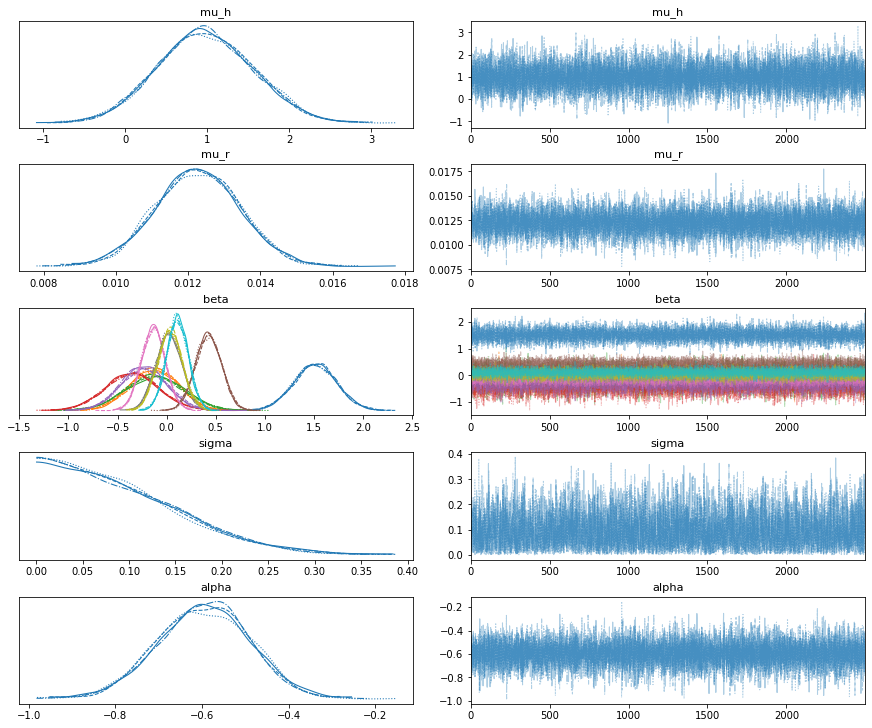

In [36]:
az.plot_trace(model2_data, compact=True, var_names=["mu_h", "mu_r", "beta", "sigma", "alpha"])

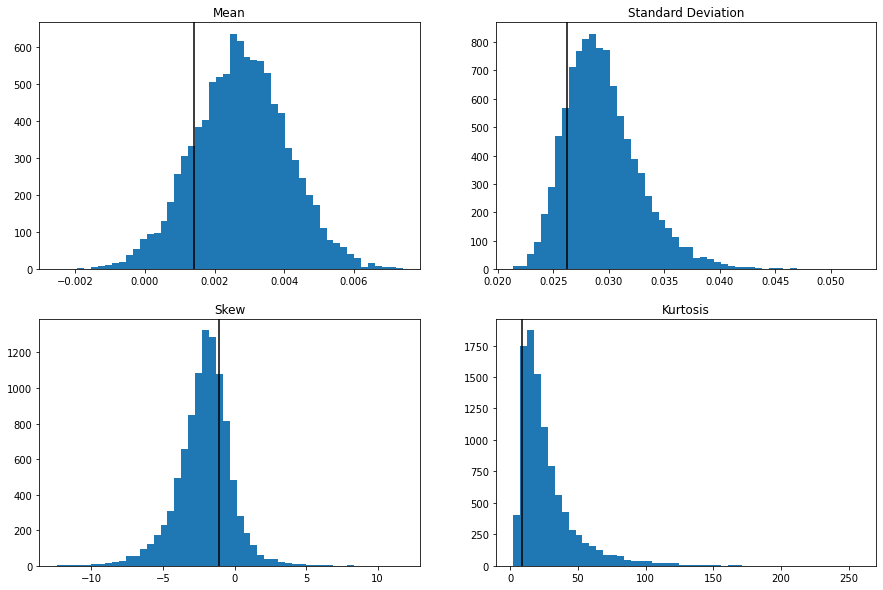

In [38]:
fig = diagnostics.plot_moment_checks(model2_data)

<AxesSubplot:xlabel='r / r_tilde'>

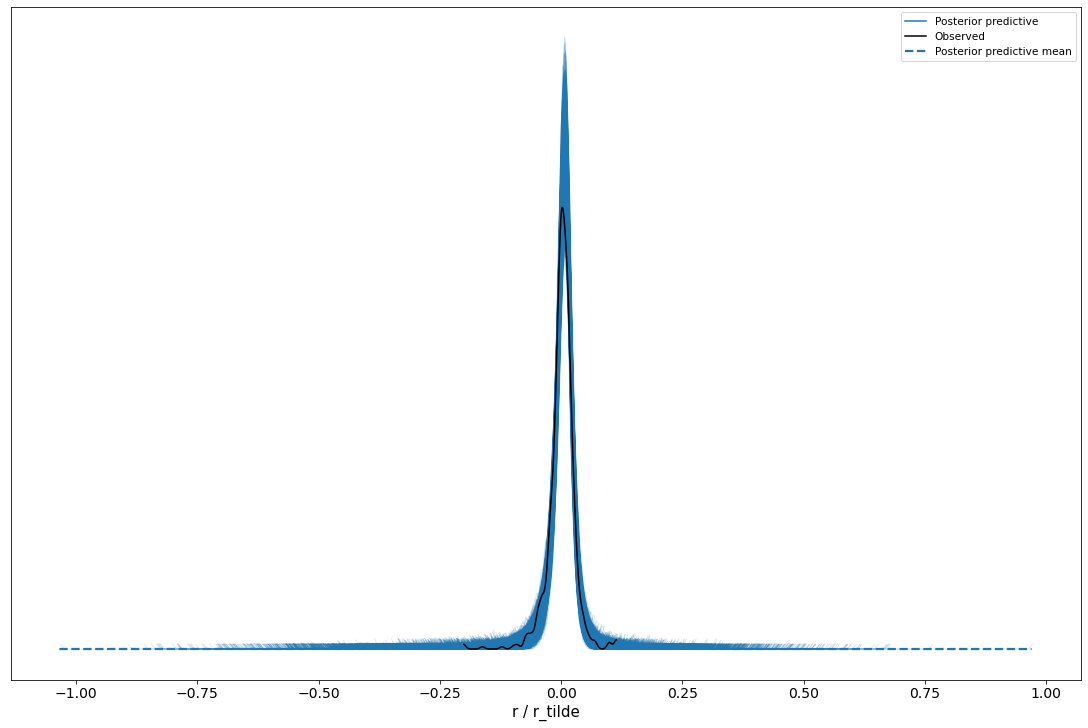

In [39]:
az.plot_ppc(model2_data, data_pairs={"r": "r_tilde"})

In [40]:
diagnostics.exceedances(model2_data)

{1: 0.13999999999999999,
 5: 0.95,
 10: 7.17,
 25: 29.23,
 50: 56.28999999999999,
 75: 76.59,
 90: 89.31,
 95: 93.64,
 99: 98.50999999999999}

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


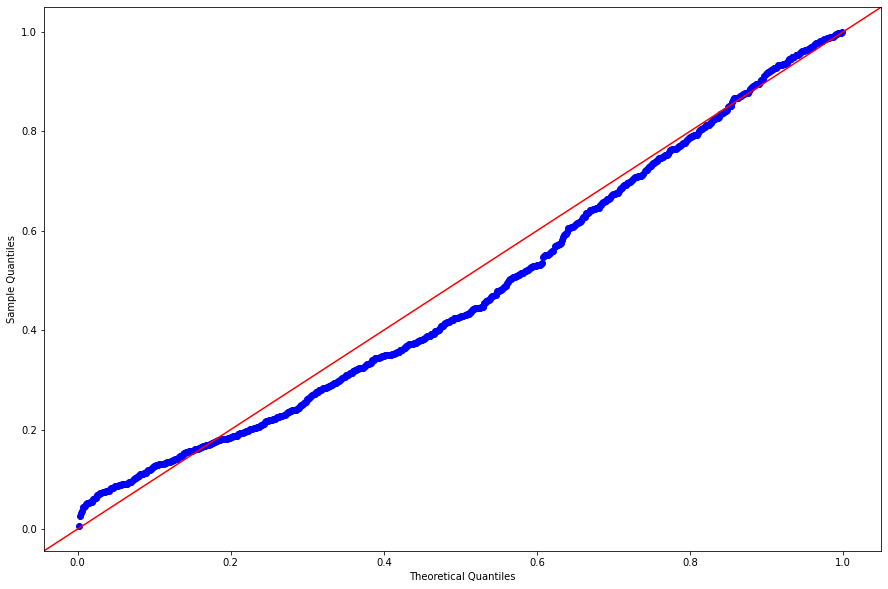

In [41]:
fig = diagnostics.plot_qq(model2_data)

In [47]:
waic1, waic_var1 = diagnostics.waic(model1_data)

In [46]:
waic2, waic_var2 = diagnostics.waic(model2_data)

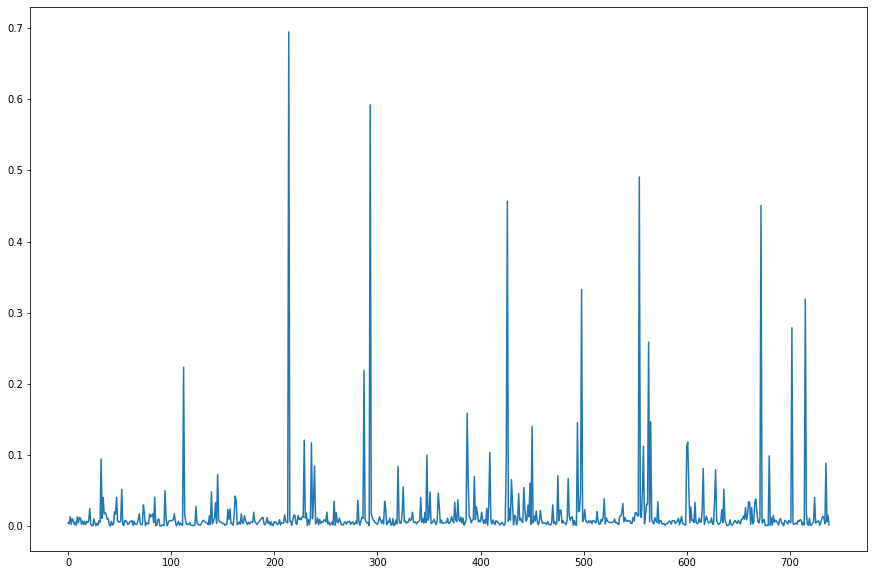

In [49]:
plt.plot(waic_var1)

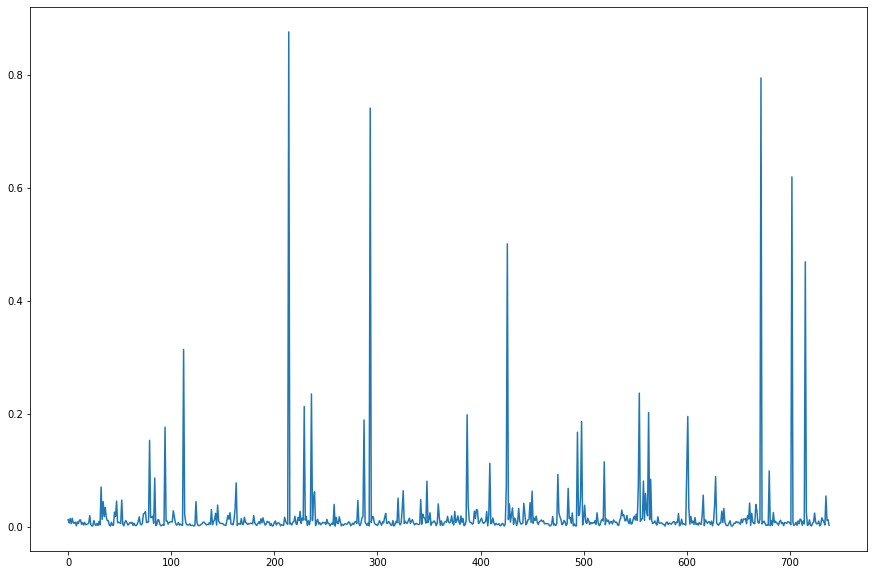

In [50]:
plt.plot(waic_var2)

In [51]:
waic1 - waic2

-15.473448593879084